In [1]:
library(goldmine)
library(ggplot2)
library(dplyr)
library(parallel)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘pac

In [2]:
## Function
find_motif_cluster <- function(meme,phastcon30way_perbin,motif_cluster,full.only=F,min_nmotif=3,btwn_mt_max_gap=30,bin_size=10) {
  cat('Start with',length(phastcon30way_perbin),'genes...\n')
  # Filter by motif order
  clst_ord_motifs <- lapply(phastcon30way_perbin, function(x) {
    mc=motif_cluster
    
    name <- x$X %>% unique
    gene_strand <- meme$strand[which(meme$seq_name == name)] %>% unique
    if (gene_strand=='+') {
      coord_sorted <- x[order(x$start),]
    } else {
      coord_sorted <- x[order(x$start,decreasing = T),]
    }
    meme_seq <- grep('^MEME',coord_sorted$meme, value = T)
    meme_seq <- paste0(meme_seq,collapse = ',') %>% strsplit(split=',') %>% unlist %>% unique
    if (length(meme_seq) >= min_nmotif) {
      meme_annot <- subset(meme, seq_name == name) 
      meme_annot <- meme_annot[match(meme_seq,meme_annot$meme_name),]
      a <- meme_annot$site_strand[1]
      b <- mc[meme_annot$meme_name[1]] %>% unname()
      if(a != b) {
        mc <- mc[length(mc):1]
        mc <- ifelse(mc=='+','-','+')
      }
      
      mc_order <- 1:length(mc)
      names(mc_order) <- names(mc)
      
      order <- mc_order[meme_seq] %>% unname()
      
      order_check <- identical(order,sort(order))
      strandness_check <- identical(meme_annot$site_strand,unname(mc[meme_seq]))
      
      if (order_check & strandness_check) {
        gaps <- data.frame(meme_start = order[which(abs(diff(order))>1)], 
                           meme_end = order[which(abs(diff(order))>1)+1])
        if(nrow(gaps)!=0) {
          gaps <- apply(gaps,1,function(x){
            mm <- mc_order[(x[1]+1):(x[2]-1)] %>% names()
            meme_annot <- subset(meme, meme_name %in% mm) %>% select(meme_name, site_width)
            meme_annot <- meme_annot[!duplicated(meme_annot$meme_name),]
            mm_size <- meme_annot$site_width[which(meme_annot$meme_name %in% mm)] %>% sum()
            meme_start <- mc_order[mc_order %in% x[1]] %>% names()
            meme_end <- mc_order[mc_order %in% x[2]] %>% names()
            meme_annot <- subset(meme, seq_name %in% name)
            gap_size <- meme_annot$site_start[which(meme_annot$meme_name == meme_end)] - 
              (meme_annot$site_start[which(meme_annot$meme_name == meme_start)] + 
                 meme_annot$site_width[which(meme_annot$meme_name == meme_start)])
            mm <- paste0(mm,collapse = ',')
            df <- data.frame(meme_start = meme_start, meme_end = meme_end, mm = mm,
                             mm_size = mm_size, gap_size = gap_size)
            return(df)
          })
          gaps <- do.call('rbind',gaps)
        } else {
          gaps <- matrix(ncol = 5, nrow = 0) %>% as.data.frame()
          colnames(gaps) <- c('meme_start','meme_end','mm','mm_size','gap_size')
        }
        
        return(list(dt = data.frame(seq_name = name,
                                    meme_seq = paste0(meme_seq,collapse = ','),
                                    ref_motif = paste0(names(mc),collapse = ',')),
                    gaps = gaps))
      }
    }
  })
  
  cat('Remove',length(clst_ord_motifs[(lapply(clst_ord_motifs,is.null) %>% unlist)]),'genes because of the order and/or strandness of their motifs \n')
  clst_ord_motifs <- clst_ord_motifs[!(lapply(clst_ord_motifs,is.null) %>% unlist)]
  
  # Filter by whether or not has enough space for missing motifs
  clst_ord_motifs <- lapply(clst_ord_motifs,function(x){
    if (nrow(x[["gaps"]])==0){
      
      return(x[["dt"]])
    } else {
      gaps_check <- x[["gaps"]]
      gaps_check$pass <- apply(gaps_check,1,function(x){
        num_mm <- strsplit(x[3],split = ',') %>% unlist %>% length
        mm_size <- x[4] %>% as.numeric()
        max_allowed_gs <- mm_size + (num_mm+1)*btwn_mt_max_gap
        gs <- x[5] %>% as.numeric
        pass_or_not <- (mm_size < gs) & (gs < max_allowed_gs)
        return(pass_or_not)
      }) 
      
      if (all(gaps_check$pass)){
        return(x[["dt"]])
      }
    }
  })
  
  cat('Remove',length(clst_ord_motifs[(lapply(clst_ord_motifs,is.null) %>% unlist)]),'genes with partial motif clusters because of not enough space for missing motifs \n')
  clst_ord_motifs <- clst_ord_motifs[!(lapply(clst_ord_motifs,is.null) %>% unlist)]
  clst_ord_motifs <- do.call('rbind',clst_ord_motifs)
  
  # Calculate number of bins for flanks for missing motifs at two ends
  cat('Calculate the number of bins at either end of genes that lack some motif there \n')
  clst_ord_motifs <- apply(clst_ord_motifs,1,function(x){
    motifs <- strsplit(x[2],split = ',') %>% unlist
    ordered_motifs <- strsplit(x[3],split = ',') %>% unlist
    leftmost_motif <- motifs[1]
    rightmost_motif <- motifs[length(motifs)]
    
    if(leftmost_motif==ordered_motifs[1]) {flank1 <- NA} else {flank1 <- ordered_motifs[1:(which(ordered_motifs==leftmost_motif)-1)]}
    if(rightmost_motif==ordered_motifs[length(ordered_motifs)]) {flank2 <- NA} else {
      flank2 <-  ordered_motifs[(which(ordered_motifs==rightmost_motif)+1):length(ordered_motifs)]
    }
    
    flank1_width <- sum(meme$site_width[match(flank1,meme$meme_name)],na.rm = T) + 
      length(flank1[!is.na(flank1)])*btwn_mt_max_gap
    flank2_width <- sum(meme$site_width[match(flank2,meme$meme_name)],na.rm = T) + 
      length(flank2[!is.na(flank2)])*btwn_mt_max_gap
    
    flank1_nbin <- round(flank1_width/bin_size)
    flank2_nbin <- round(flank2_width/bin_size)
    
    return(c(x,leftmost_motif,rightmost_motif,paste0(flank1,collapse=','),paste0(flank2,collapse=','),flank1_width,flank2_width,flank1_nbin,flank2_nbin))
  }) %>% t()
  
  colnames(clst_ord_motifs) <- c('seq_name','meme_seq','ref_motif','leftmost_motif','rightmost_motif',
                                 'flank1','flank2','flank1_width','flank2_width','flank1_nbin','flank2_nbin')
  clst_ord_motifs <- as.data.frame(clst_ord_motifs) %>% mutate(flank1_nbin = as.numeric(flank1_nbin), flank2_nbin = as.numeric(flank2_nbin))
  clst_ord_motifs[,c('strand','chr','start','end','flanked_start','flanked_end')] <- NA
  clst_ord_motifs[,c('strand','chr')] <- meme[match(clst_ord_motifs$seq_name,meme$seq_name),c('strand','chr')]
  
  clst_ord_motifs[,c('start','end','flanked_start','flanked_end')] <- apply(clst_ord_motifs,1,function(x) {
    if (x[12] == '+') {
      start <- meme$start[which(meme$seq_name == x[1] & meme$meme_name == x[4])] 
      end <- meme$end[which(meme$seq_name == x[1] & meme$meme_name == x[5])]
      flanked_start <- start - as.numeric(x[8])
      flanked_end <- end + as.numeric(x[9])
    } else {
      start <- meme$start[which(meme$seq_name == x[1] & meme$meme_name == x[5])] 
      end <- meme$end[which(meme$seq_name == x[1] & meme$meme_name == x[4])]
      flanked_start <- start - as.numeric(x[9])
      flanked_end <- end + as.numeric(x[8])
    }
    return(c(start,end,flanked_start,flanked_end))
  }) %>% t()
  
  genes_w_full_clusters <- clst_ord_motifs$seq_name[which(clst_ord_motifs$meme_seq==clst_ord_motifs$ref_motif)]
  if (full.only) {
    cat('Find only genes with full motif cluster...\n')
    cat('There are',length(genes_w_full_clusters),'genes with full cluster\n')
    clst_ord_motifs <- clst_ord_motifs[which(clst_ord_motifs$seq_name %in% genes_w_full_clusters),]
  }
  
  phastcon30way_perbin <- phastcon30way_perbin[which(names(phastcon30way_perbin) %in% clst_ord_motifs$seq_name)]
  
  # Annotate flank bins
  bin_annot <- lapply(phastcon30way_perbin,function(x){
    name <- unique(x$X)
    strand <- meme$strand[which(meme$seq_name == name)] %>% unique
    if (strand == '+') {x <- x[order(as.numeric(x$start)),]} else {
      x <- x[order(as.numeric(x$start), decreasing = T),]
    }
    x$motif_cluster <- x$meme
    leftmost_motif <- clst_ord_motifs$leftmost_motif[which(clst_ord_motifs$seq_name==name)]
    leftmost_motif_start <- grep(leftmost_motif,x$meme)[1]
    flank1_start <- leftmost_motif_start - clst_ord_motifs$flank1_nbin[which(clst_ord_motifs$seq_name==name)]
    flank1_start <- max(flank1_start,1)
    
    rightmost_motif <- clst_ord_motifs$rightmost_motif[which(clst_ord_motifs$seq_name==name)]
    rightmost_motif_end <- grep(rightmost_motif,x$meme)
    rightmost_motif_end <- rightmost_motif_end[length(rightmost_motif_end)]
    flank2_end <- rightmost_motif_end + clst_ord_motifs$flank2_nbin[which(clst_ord_motifs$seq_name==name)]
    flank2_end <- min(flank2_end,nrow(x))
    
    x$motif_cluster[flank1_start:flank2_end] <- 'motif_cluster'
    x$full_or_partial <- ifelse(name %in% genes_w_full_clusters,TRUE,FALSE)
    return(x)
  })
  
  return(bin_annot)
}

load_meme_output <- function(utr3_bed,meme_dir,fprefix,num_motif=5){
  for (memename in paste0('MEME-',1:num_motif)) {
    if (memename == 'MEME-1') {
      meme_res <- read.delim(paste0(meme_dir,fprefix,'_',memename,'.txt'), header = F)
      meme_res$meme_name <- memename
    } else {
      df <- read.delim(paste0(meme_dir,fprefix,'_',memename,'.txt'), header = F)
      df$meme_name <- memename
      meme_res <- rbind(meme_res,df)
      rm(df)
    }
  }
  
  colnames(meme_res) <- c('seq_name','site_strand','site_start','pval','flank1','site','flank2','meme_name')
  meme_res$strand <- str_extract_all(meme_res$seq_name, "\\(([^)]+)\\)") %>% unlist
  meme_res$strand <- gsub("\\(|\\)","",meme_res$strand)
  meme_res$cis <- meme_res$site_strand==meme_res$strand
  meme_res$seq_name <- gsub("\\(([^)]+)\\)","",meme_res$seq_name)
  meme_res$chr <- utr3_bed$chr[match(meme_res$seq_name,utr3_bed$seq_name)]
  meme_res$range_start <- utr3_bed$start[match(meme_res$seq_name,utr3_bed$seq_name)]
  meme_res$range_end <- utr3_bed$end[match(meme_res$seq_name,utr3_bed$seq_name)]
  meme_res$site_width <- nchar(meme_res$site)
  meme_res$start <- ifelse(meme_res$strand=='+',meme_res$range_start+meme_res$site_start-1,meme_res$range_end-meme_res$site_start+1-meme_res$site_width+1)
  meme_res$end <- meme_res$start+meme_res$site_width-1
  
  return(meme_res)
}

repeat_elt_annot <- function(bin,repeat_elt) {
  bin$repNameID <- NA
  bin$repName <- NA
  bin$repClass <- NA
  bin$repFamily <- NA
  bin$re_width <- NA
  ovl <- findOverlaps(bin,repeat_elt) %>% as.data.frame()
  ovl_spl <- split(ovl, ovl$queryHits)
  if(length(ovl_spl)>0) {
    for (i in 1:length(ovl_spl)) {
      x <- ovl_spl[[i]] 
      query_idx <- unique(x$queryHits)
      bin$repNameID[query_idx] <- paste0(x$subjectHits,collapse=',')
      bin$repName[query_idx] <- paste0(repeat_elt$repName[x$subjectHits],collapse=',')
      bin$repClass[query_idx] <- paste0(repeat_elt$repClass[x$subjectHits],collapse=',')
      bin$repFamily[query_idx] <- paste0(repeat_elt$repFamily[x$subjectHits],collapse=',')
      bin$re_width[query_idx] <- paste0(repeat_elt$re_width[x$subjectHits],collapse=',')
    }
  }
  return(bin)
}

rep_enrich_calc <- function(bin_annot_re,category,repeat_elt,bin_size=10,threshold=0.7,
                            re.filter=T,keep.all.genes=T,max.ovl.re.only=T) {
  all_genes <- unique(bin_annot_re$X)
  bin_annot_re <- bin_annot_re[bin_annot_re$motif_cluster==category&
                                 bin_annot_re$re_or_not,]
  rebin_count <- bin_annot_re %>% count(X,repNameID,repName)
  rebin_count <- tidyr::separate_rows(rebin_count,2:3,sep = ",") %>% as.data.frame()
  rebin_count <- aggregate(n~X+repNameID+repName,rebin_count,FUN=sum)
  rebin_count$re_width <- repeat_elt$re_width[as.integer(rebin_count$repNameID)]
  rebin_count$perct_width_match <- rebin_count$n*bin_size/rebin_count$re_width
  rebin_count$pass <- rebin_count$perct_width_match >= threshold
  if (re.filter) {rebin_count <- rebin_count[rebin_count$pass,]}
  if (keep.all.genes) {
    remaining_genes <- setdiff(all_genes,unique(rebin_count$X))
    rebin_count[(nrow(rebin_count)+1):(nrow(rebin_count)+length(remaining_genes)),'X'] <- remaining_genes
  }
  if (max.ovl.re.only) {
    rebin_count <- rebin_count %>% group_by(X) %>% slice_max(perct_width_match, n = 1) %>% 
      slice_max(re_width, n = 1) %>% as.data.frame()
  }
  rebin_count$repFamily <- sub(":.*", "",rebin_count$repName)
  rebin_count$repFamily[is.na(rebin_count$repFamily)] <- 'No repetitive element'
  return(rebin_count)
}

In [3]:
### Load & Process Data
setwd('~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/meme_motif_results/')
wd <- '~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/'

In [4]:
## Repeat Element Analysis
repeat_elt <- read.delim('~/Downloads/hg38_rmsk/rmsk.txt',header = F)
colnames(repeat_elt) <- c('bin','swScore','milliDiv','milliDel','milliIns','genoName',
                          'genoStart','genoEnd','genoLeft','strand','repName','repClass',
                          'repFamily','repStart','repEnd','repLeft','id')
# Note: all start coordinates in our database are 0-based, not 1-based. So no need to modify it
colnames(repeat_elt)[c(6,7,8)] <- c('chr','start','end')
repeat_elt$repClass <- apply(repeat_elt,1,function(x){
  conc <- paste0(x[13:12],collapse = ':')
  return(conc)
})
repeat_elt$repName <- apply(repeat_elt,1,function(x){
  conc <- paste0(x[12:11],collapse = ':')
  return(conc)
})
repeat_elt <- repeat_elt %>% mutate(re_width = end - start + 1)
repeat_elt_gr <- makeGRanges(repeat_elt,strand = T)

### Shortening

In [5]:
## UTR3
sutr3_bed <- read.delim(paste0(wd,'WUI_APA_genes_UTR3_shortening_ranges','.bed'),
                       header = F)
colnames(sutr3_bed) <- c('chr','start','end','seq_name','score','strand')
## Meme Motif Results
meme_dir <- paste0(wd,'meme_motif_results/')
smemeres <- load_meme_output(utr3_bed = sutr3_bed, meme_dir = meme_dir,
                             fprefix = 'WUI_APA_genes_UTR3_shortening_ranges')
## PhastCon30Score by Bin
spc30 <- readRDS('WUI_APA_genes_UTR3_shortening_ranges_phastcon30way_perbin.rds')
spc30 <- do.call('rbind',spc30)
spc30 <- spc30 %>% mutate(start = as.numeric(start), end = as.numeric(end),
                                    phastcon30way = as.numeric(phastcon30way))
spc30_spl <- split(spc30,spc30$X)
spc30_spl <- lapply(spc30_spl,function(x){
  gene <- x$X %>% unique
  if (gene %in% sutr3_bed$seq_name[sutr3_bed$strand=='+']) {
    x$strand <- '+'
  } else {x$strand <- '-'}
  return(x)
})
sbin_annot <- find_motif_cluster(meme=smemeres,phastcon30way_perbin=spc30_spl,
                                           motif_cluster=c('MEME-1'='-','MEME-2'='-','MEME-4'='-',
                                                           'MEME-3'='+','MEME-5'='-'),
                                           full.only=F,min_nmotif=3,btwn_mt_max_gap=30,bin_size=10)

Start with 79 genes...
Remove 48 genes because of the order and/or strandness of their motifs 
Remove 2 genes with partial motif clusters because of not enough space for missing motifs 
Calculate the number of bins at either end of genes that lack some motif there 


In [ ]:
#### Genes with Motif Cluster (Full or Partial) Only
# Coordinate Expansion
snuc <- lapply(sbin_annot,function(x){
  x$phastcon30way <- NULL
  df <- apply(x,1,function(x){
    width <- as.numeric(x[4])
    df <- matrix(nrow = width, ncol = length(x)-1) %>% as.data.frame()
    colnames(df) <- c('chr','start','end','strand','X','meme','motif_cluster','full_or_partial')
    df$chr <- x[1]
    df$start <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$end <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$strand <- x[5]
    df$X <- x[6]
    df$meme <- x[7]
    df$motif_cluster <- x[8]
    df$full_or_partial <- x[9]
    return(df)
  })
  df <- do.call('rbind',df)
  return(df)
})
snuc <- do.call('rbind',snuc)
snuc_gr <- makeGRanges(snuc,strand=T)
snuc_re_annot <- repeat_elt_annot(snuc_gr,repeat_elt_gr)
snuc_re_annot_bu <- snuc_re_annot
snuc_re_annot <- snuc_re_annot %>% as.data.frame()

# Annotate whether or not a nucleotide overlaps with any RE
snuc_re_annot$re_or_not <- apply(snuc_re_annot,1,function(x){
  rep_colsidx <- grep('^rep',colnames(snuc_re_annot))
  if(all(is.na(x[rep_colsidx]))){
    return(FALSE)
  } else {
    return(TRUE)
  }
})
# Calculate RE nucleotide percentage in motif cluster region and non-motif cluster region
s_re_percent <- snuc_re_annot %>% group_by(X,motif_cluster) %>% summarize(re_nuc_pct = sum(re_or_not)/n())

`summarise()` has grouped output by 'X'. You can override using the `.groups`
argument.


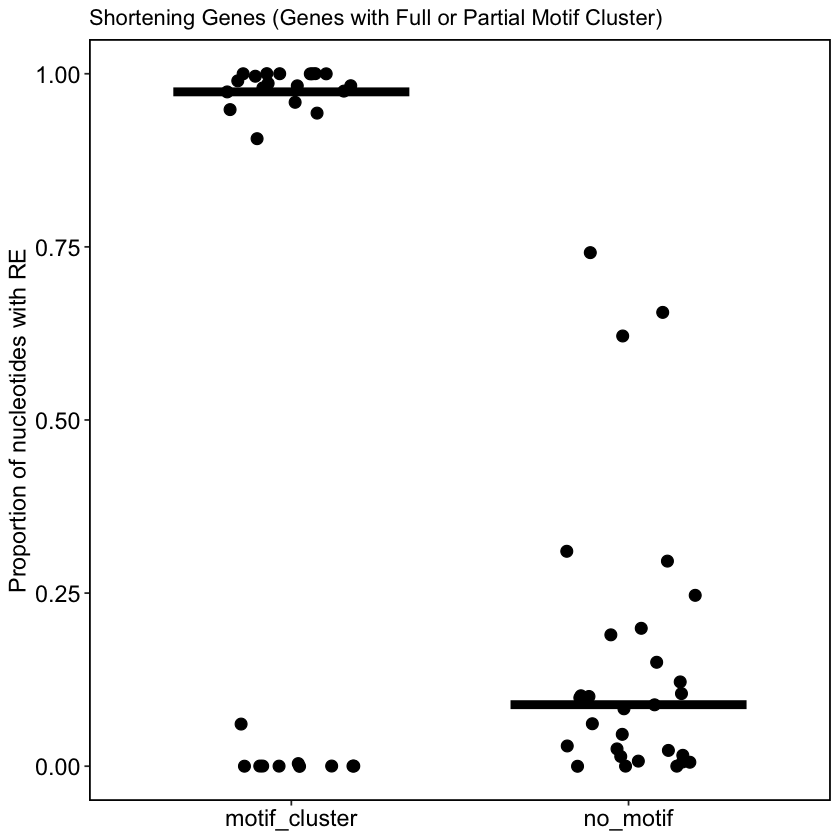

In [ ]:
# Plot proportion of nucleotides with RE in motif cluster vs non-motif cluster regions
p1 <- ggplot(s_re_percent, aes(x=motif_cluster, y=re_nuc_pct)) + geom_boxplot(outlier.shape = NA, color = 'white') + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123)) +
  stat_summary(fun = median, geom = "crossbar", color = "black", width = 0.7, linewidth = 1) + 
  labs(y= "Proportion of nucleotides with RE",title = "Shortening Genes (Genes with Full or Partial Motif Cluster)") + 
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p1
# ggsave('u10_uro_shortening_GeneswMotifClusters_PorpNucWRE.png',width = 8, height = 8, units = 'in',p1)

In [ ]:
# Test for normality
s_re_percent <- reshape(as.data.frame(s_re_percent),idvar = 'X', 
                        timevar = 'motif_cluster', direction = 'wide')
s_re_percent$motif_nomotif <- s_re_percent$re_nuc_pct.motif_cluster - 
  s_re_percent$re_nuc_pct.no_motif
shapiro.test(s_re_percent$motif_nomotif)


	Shapiro-Wilk normality test

data:  s_re_percent$motif_nomotif
W = 0.80487, p-value = 0.0001023


In [ ]:
# Paired Samples Wilcoxon-test of RE nucleotide percentage in motif cluster vs non-motif cluster regions
s_wilcoxon_result = wilcox.test(s_re_percent$re_nuc_pct.motif_cluster, 
                                s_re_percent$re_nuc_pct.no_motif, paired = TRUE,
                                alternative = "greater")
s_wilcoxon_result

Warning message in wilcox.test.default(s_re_percent$re_nuc_pct.motif_cluster, s_re_percent$re_nuc_pct.no_motif, :
“cannot compute exact p-value with zeroes”



	Wilcoxon signed rank test with continuity correction

data:  s_re_percent$re_nuc_pct.motif_cluster and s_re_percent$re_nuc_pct.no_motif
V = 338, p-value = 0.0001801
alternative hypothesis: true location shift is greater than 0


In [ ]:
# Repeat Element Enrichment Calculation
s_motifnuc_recompo <- rep_enrich_calc(bin_annot_re = as.data.frame(snuc_re_annot),
                                      category = 'motif_cluster',
                                      repeat_elt = repeat_elt_gr,
                                      bin_size = 1, threshold = 0.5, re.filter = T,
                                      keep.all.genes = T, max.ovl.re.only = T)
# Summary of RE family proportions
sdf <- s_motifnuc_recompo %>% group_by(repFamily) %>%
  summarise(count = n()) %>%
  mutate(proportion = (count / sum(count)))
sdf

repFamily,count,proportion
<chr>,<int>,<dbl>
Alu,19,0.65517241
No repetitive element,9,0.31034483
Simple_repeat,1,0.03448276


In [ ]:
## Genome Range plot
# Alu SINE Elements around Motif Cluster Regions
snuc <- lapply(sbin_annot,function(x){
  x$phastcon30way <- NULL
  df <- apply(x,1,function(x){
    width <- as.numeric(x[4])
    df <- matrix(nrow = width, ncol = length(x)-1) %>% as.data.frame()
    colnames(df) <- c('chr','start','end','strand','X','meme','motif_cluster','full_or_partial')
    df$chr <- x[1]
    df$start <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$end <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$strand <- x[5]
    df$X <- x[6]
    df$meme <- x[7]
    df$motif_cluster <- x[8]
    df$full_or_partial <- x[9]
    return(df)
  })
  df <- do.call('rbind',df)
  return(df)
})
snuc_flanked <- mclapply(snuc,function(x){
  repName_pttn <- '^Alu:SINE:Alu'
  flank <- 5000
  chr <- unique(x$chr)
  strand <- unique(x$strand)
  gene <- unique(x$X)
  x <- x[order(x$start,decreasing = F),]
  mid_motifcluster <- sum(range(x$start[x$motif_cluster=='motif_cluster'])) %/% 2
  flank5 <- x$start[1]-(mid_motifcluster-flank)
  if (flank5 > 0) {
    flank5_coord <- matrix(ncol = ncol(x), nrow = flank5) %>% as.data.frame()
    colnames(flank5_coord) <- colnames(x)
    flank5_coord$start <- seq((mid_motifcluster-flank),(x$start[1]-1))
    flank5_coord$end <- flank5_coord$start
    flank5_coord$meme <- 'no_motif'
    flank5_coord$motif_cluster <- 'no_motif'
    x <- rbind(flank5_coord,x)
  } else if (flank5 < 0) {
    x <- x[-c(1:abs(flank5)),]
  }
  flank3 <- mid_motifcluster+flank-x$start[nrow(x)]
  if (flank3 > 0) {
    flank3_coord <- matrix(ncol = ncol(x), nrow = flank3) %>% as.data.frame()
    colnames(flank3_coord) <- colnames(x)
    flank3_coord$start <- seq((x$start[nrow(x)]+1),(mid_motifcluster+flank))
    flank3_coord$end <- flank3_coord$start
    flank3_coord$meme <- 'no_motif'
    flank3_coord$motif_cluster <- 'no_motif'
    x <- rbind(x,flank3_coord)
  } else if (flank3 < 0) {
    x <- x[-c((nrow(x)-abs(flank3)+1):nrow(x)),]
  }
  if (strand=='-') {
    x <- x[order(x$start,decreasing = T),]
  }
  x$chr <- chr
  x$strand <- strand
  x$X <- gene
  x$midpt <- FALSE
  x$midpt[x$start==mid_motifcluster] <- TRUE
  x <- makeGRanges(x,strand=T)
  x_re_annot <- repeat_elt_annot(x,repeat_elt_gr) %>% as.data.frame()
  repName_cidx <- grep('\\brepName\\b',colnames(x_re_annot))
  
  x_re_annot$repName_count <- apply(x_re_annot,1,function(x){
    repNames <- strsplit(x[repName_cidx],split = ',') %>% unlist()
    count <- sum(grepl(repName_pttn,repNames))
    return(count)
  })
  
  return(x_re_annot)
  
},mc.cores = 4)
snuc_flanked_bu <- snuc_flanked

for (i in 1:length(snuc_flanked)){
  if (i == 1) {
    sredist <- matrix(nrow = nrow(snuc_flanked[[i]]), ncol = 0) %>% as.data.frame()
  }
  sredist <- cbind(sredist,snuc_flanked[[i]]$repName_count > 0)
  colnames(sredist)[i] <- unique(snuc_flanked[[i]]$X)
}

spos <- data.frame(position = rownames(sredist),porp.repName = rowSums(sredist)/ncol(sredist))
spos$position <- seq(-5000,5000)

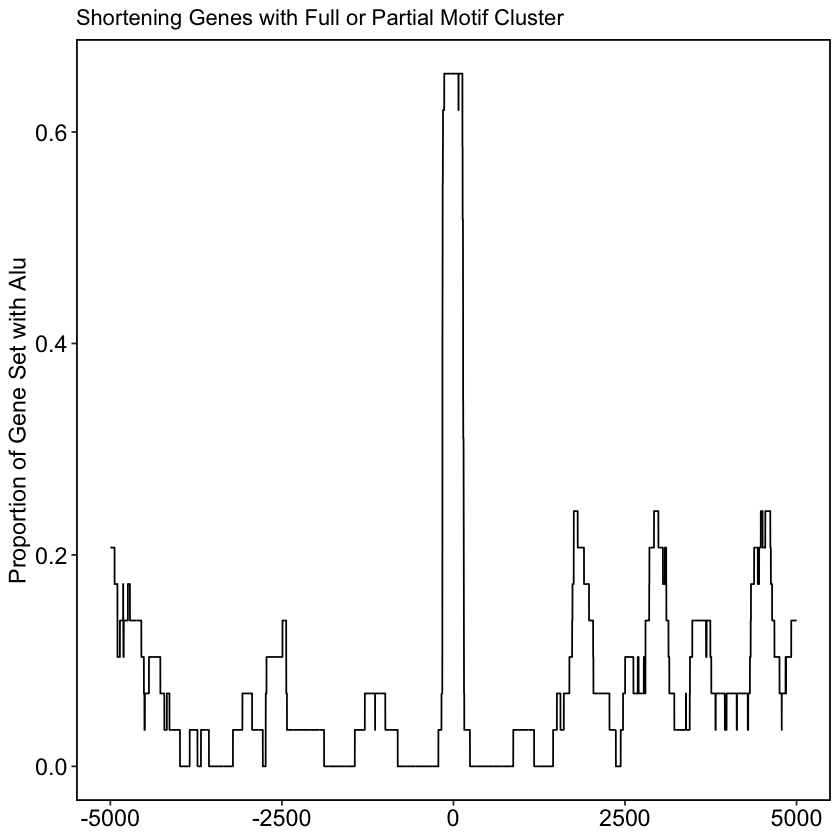

In [ ]:
# Plot Alu SINE distribution around motif cluster (full or partial) regions
sp <- ggplot(data=spos, aes(x=position,y=porp.repName)) + 
  geom_line(stat="identity",linewidth = 0.5) +
  labs(y= "Proportion of Gene Set with Alu", title = 'Shortening Genes with Full or Partial Motif Cluster') +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14),
        legend.text = element_text(colour = 'black', size = 12),
        legend.title = element_text(color = 'black', size = 14),
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
sp
# ggsave('u10_uro_shortening_GeneswMotifClusters_PorpAluSINEAlu_dist.png', width = 14, height = 4, units = 'in', sp)

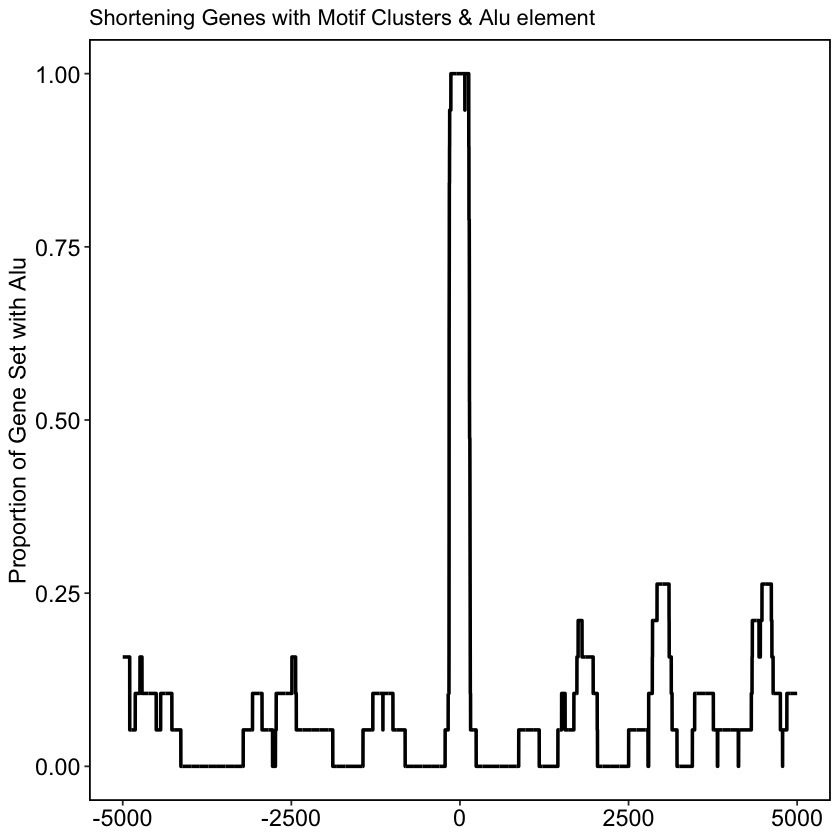

In [ ]:
### Just motif cluster (full or partial) genes with Alu elements
snuc_flanked_Alu <- snuc_flanked[s_motifnuc_recompo$X[s_motifnuc_recompo$repFamily=='Alu']]
for (i in 1:length(snuc_flanked_Alu)){
  if (i == 1) {
    sredist_Alu <- matrix(nrow = nrow(snuc_flanked_Alu[[i]]), ncol = 0) %>% as.data.frame()
  }
  sredist_Alu <- cbind(sredist_Alu,snuc_flanked_Alu[[i]]$repName_count > 0)
  colnames(sredist_Alu)[i] <- unique(snuc_flanked_Alu[[i]]$X)
}

sposAlu <- data.frame(position = rownames(sredist_Alu),porp.repName = rowSums(sredist_Alu)/ncol(sredist_Alu))
sposAlu$position <- seq(-5000,5000)

spA <- ggplot(data=sposAlu, aes(x=position,y=porp.repName)) + 
  geom_line(stat="identity",linewidth = 1) +
  labs(y= "Proportion of Gene Set with Alu", title = 'Shortening Genes with Motif Clusters & Alu element') +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14),
        legend.text = element_text(colour = 'black', size = 12),
        legend.title = element_text(color = 'black', size = 14),
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
spA
# ggsave('u10_uro_shortening_GeneswMotifClustersAlu_PorpAluSINEAlu_dist.png', width = 14, height = 4, units = 'in', spA)

### Lengthening

In [30]:
### Lengthening
## UTR3
lutr3_bed <- read.delim(paste0(wd,'WUI_APA_genes_UTR3_lengthening_ranges','.bed'),
                        header = F)
colnames(lutr3_bed) <- c('chr','start','end','seq_name','score','strand')

## Meme Motif Results
lmemeres <- load_meme_output(utr3_bed = lutr3_bed, meme_dir = meme_dir,
                             fprefix = 'WUI_APA_genes_UTR3_lengthening_ranges')
## PhastCon30Score by Bin
lpc30 <- readRDS('WUI_APA_genes_UTR3_lengthening_ranges_phastcon30way_perbin.rds')
lpc30 <- do.call('rbind',lpc30)
lpc30 <- lpc30 %>% mutate(start = as.numeric(start), end = as.numeric(end),
                          phastcon30way = as.numeric(phastcon30way))
lpc30_spl <- split(lpc30,lpc30$X)
lpc30_spl <- lapply(lpc30_spl,function(x){
  gene <- x$X %>% unique
  if (gene %in% lutr3_bed$seq_name[lutr3_bed$strand=='+']) {
    x$strand <- '+'
  } else {x$strand <- '-'}
  return(x)
})
lbin_annot <- find_motif_cluster(meme=lmemeres,phastcon30way_perbin=lpc30_spl,
                                 motif_cluster=c('MEME-3'='+','MEME-1'='+','MEME-2'='+',
                                                 'MEME-5'='-','MEME-4'='+'),
                                 full.only=F,min_nmotif=3,btwn_mt_max_gap=40,bin_size=10)

Start with 64 genes...
Remove 33 genes because of the order and/or strandness of their motifs 
Remove 1 genes with partial motif clusters because of not enough space for missing motifs 
Calculate the number of bins at either end of genes that lack some motif there 


In [ ]:
## Coordinate Expansion
lnuc <- lapply(lbin_annot,function(x){
  x$phastcon30way <- NULL
  df <- apply(x,1,function(x){
    width <- as.numeric(x[4])
    df <- matrix(nrow = width, ncol = length(x)-1) %>% as.data.frame()
    colnames(df) <- c('chr','start','end','strand','X','meme','motif_cluster','full_or_partial')
    df$chr <- x[1]
    df$start <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$end <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$strand <- x[5]
    df$X <- x[6]
    df$meme <- x[7]
    df$motif_cluster <- x[8]
    df$full_or_partial <- x[9]
    return(df)
  })
  df <- do.call('rbind',df)
  return(df)
})

# # Annotate whether or not a nucleotide overlaps with any RE
lnuc_re_annot <- mclapply(lnuc,function(x){
  x <- makeGRanges(x,strand=T)
  x_re_annot <- repeat_elt_annot(x,repeat_elt_gr) %>% as.data.frame()
  rep_colsidx <- grep('^rep',colnames(x_re_annot))
  x_re_annot$re_or_not <- apply(x_re_annot,1,function(x){
    if(all(is.na(x[rep_colsidx]))){
      return(FALSE)
    } else {
      return(TRUE)
    }
  })
  return(x_re_annot)
}, mc.cores = 4)

# Calculate RE nucleotide percentage in motif cluster region and non-motif cluster region
lnuc_re_annot <- do.call('rbind',lnuc_re_annot)
l_re_percent <- lnuc_re_annot %>% group_by(X,motif_cluster) %>% summarize(re_nuc_pct = sum(re_or_not)/n())

`summarise()` has grouped output by 'X'. You can override using the `.groups`
argument.


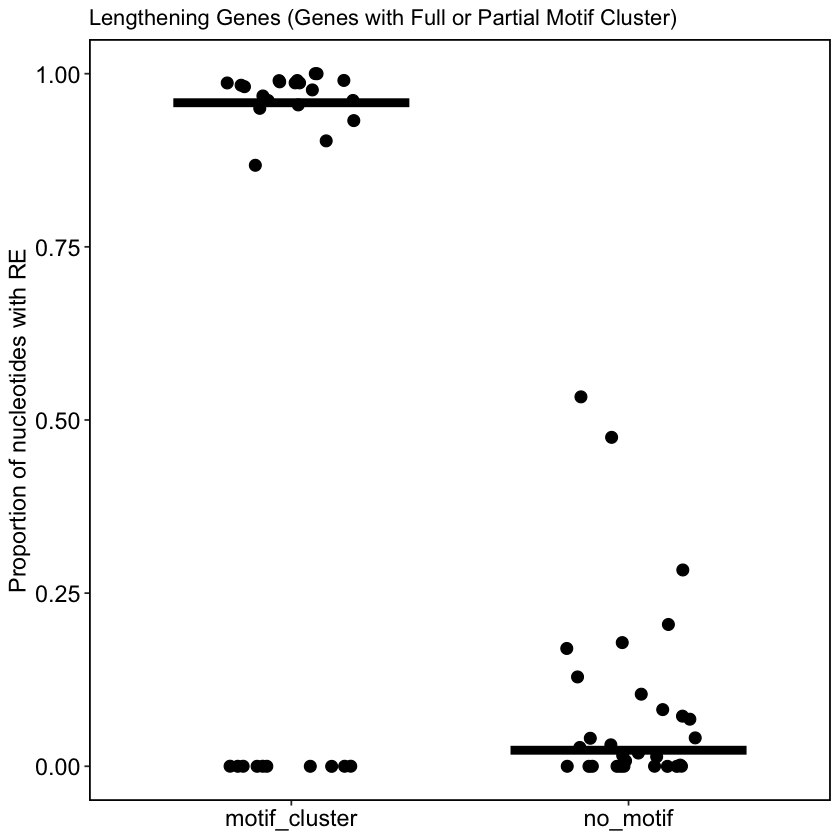

In [ ]:
# Plot proportion of nucleotides with RE in motif cluster vs non-motif cluster regions
p2 <- ggplot(l_re_percent, aes(x=motif_cluster, y=re_nuc_pct)) + geom_boxplot(outlier.shape = NA, color = 'white') + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123)) +
  stat_summary(fun = median, geom = "crossbar", color = "black", width = 0.7, linewidth = 1) + 
  labs(y= "Proportion of nucleotides with RE",title = "Lengthening Genes (Genes with Full or Partial Motif Cluster)") +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p2
# ggsave('u10_uro_lengthening_GeneswMotifClusters_PorpNucWRE.png',width = 8, height = 8, units = 'in',p2)

In [ ]:
# Test for normality
l_re_percent <- reshape(as.data.frame(l_re_percent),idvar = 'X', 
                        timevar = 'motif_cluster', direction = 'wide')
l_re_percent$motif_nomotif <- l_re_percent$re_nuc_pct.motif_cluster - 
  l_re_percent$re_nuc_pct.no_motif
shapiro.test(l_re_percent$motif_nomotif)


	Shapiro-Wilk normality test

data:  l_re_percent$motif_nomotif
W = 0.77457, p-value = 2.332e-05


In [ ]:
# Paired Samples Wilcoxon-test of RE nucleotide percentage in motif cluster vs non-motif cluster regions
l_wilcoxon_result = wilcox.test(l_re_percent$re_nuc_pct.motif_cluster, 
                                l_re_percent$re_nuc_pct.no_motif, paired = TRUE,
                                alternative = "greater")
l_wilcoxon_result

Warning message in wilcox.test.default(l_re_percent$re_nuc_pct.motif_cluster, l_re_percent$re_nuc_pct.no_motif, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(l_re_percent$re_nuc_pct.motif_cluster, l_re_percent$re_nuc_pct.no_motif, :
“cannot compute exact p-value with zeroes”



	Wilcoxon signed rank test with continuity correction

data:  l_re_percent$re_nuc_pct.motif_cluster and l_re_percent$re_nuc_pct.no_motif
V = 309, p-value = 4.272e-05
alternative hypothesis: true location shift is greater than 0


In [ ]:
# Repeat Element Enrichment Calculation
l_motifnuc_recompo <- rep_enrich_calc(bin_annot_re = as.data.frame(lnuc_re_annot),
                                      category = 'motif_cluster',
                                      repeat_elt = repeat_elt_gr,
                                      bin_size = 1, threshold = 0.5, re.filter = T,
                                      keep.all.genes = T, max.ovl.re.only = T)
# Summary of RE family proportions
ldf <- l_motifnuc_recompo %>% group_by(repFamily) %>%
  summarise(count = n()) %>%
  mutate(proportion = (count / sum(count)))
ldf

repFamily,count,proportion
<chr>,<int>,<dbl>
Alu,20,0.6666667
No repetitive element,10,0.3333333


In [ ]:
## Genome Range Plot of Alu SINE
# Alu SINE
lnuc <- lapply(lbin_annot,function(x){
  x$phastcon30way <- NULL
  df <- apply(x,1,function(x){
    width <- as.numeric(x[4])
    df <- matrix(nrow = width, ncol = length(x)-1) %>% as.data.frame()
    colnames(df) <- c('chr','start','end','strand','X','meme','motif_cluster','full_or_partial')
    df$chr <- x[1]
    df$start <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$end <- seq(as.numeric(x[2]),as.numeric(x[3]))
    df$strand <- x[5]
    df$X <- x[6]
    df$meme <- x[7]
    df$motif_cluster <- x[8]
    df$full_or_partial <- x[9]
    return(df)
  })
  df <- do.call('rbind',df)
  return(df)
})
lnuc_flanked <- mclapply(lnuc,function(x){
  repName_pttn <- '^Alu:SINE:Alu'
  flank <- 5000
  chr <- unique(x$chr)
  strand <- unique(x$strand)
  gene <- unique(x$X)
  x <- x[order(x$start,decreasing = F),]
  mid_motifcluster <- sum(range(x$start[x$motif_cluster=='motif_cluster'])) %/% 2
  flank5 <- x$start[1]-(mid_motifcluster-flank)
  if (flank5 > 0) {
    flank5_coord <- matrix(ncol = ncol(x), nrow = flank5) %>% as.data.frame()
    colnames(flank5_coord) <- colnames(x)
    flank5_coord$start <- seq((mid_motifcluster-flank),(x$start[1]-1))
    flank5_coord$end <- flank5_coord$start
    flank5_coord$meme <- 'no_motif'
    flank5_coord$motif_cluster <- 'no_motif'
    x <- rbind(flank5_coord,x)
  } else if (flank5 < 0) {
    x <- x[-c(1:abs(flank5)),]
  }
  flank3 <- mid_motifcluster+flank-x$start[nrow(x)]
  if (flank3 > 0) {
    flank3_coord <- matrix(ncol = ncol(x), nrow = flank3) %>% as.data.frame()
    colnames(flank3_coord) <- colnames(x)
    flank3_coord$start <- seq((x$start[nrow(x)]+1),(mid_motifcluster+flank))
    flank3_coord$end <- flank3_coord$start
    flank3_coord$meme <- 'no_motif'
    flank3_coord$motif_cluster <- 'no_motif'
    x <- rbind(x,flank3_coord)
  } else if (flank3 < 0) {
    x <- x[-c((nrow(x)-abs(flank3)+1):nrow(x)),]
  }
  if (strand=='-') {
    x <- x[order(x$start,decreasing = T),]
  }
  x$chr <- chr
  x$strand <- strand
  x$X <- gene
  x$midpt <- FALSE
  x$midpt[x$start==mid_motifcluster] <- TRUE
  x <- makeGRanges(x,strand=T)
  x_re_annot <- repeat_elt_annot(x,repeat_elt_gr) %>% as.data.frame()
  repName_cidx <- grep('\\brepName\\b',colnames(x_re_annot))
  
  x_re_annot$repName_count <- apply(x_re_annot,1,function(x){
    repNames <- strsplit(x[repName_cidx],split = ',') %>% unlist()
    count <- sum(grepl(repName_pttn,repNames))
    return(count)
  })
  
  return(x_re_annot)
  
},mc.cores = 4)
lnuc_flanked_bu <- lnuc_flanked

for (i in 1:length(lnuc_flanked)){
  if (i == 1) {
    lredist <- matrix(nrow = nrow(lnuc_flanked[[i]]), ncol = 0) %>% as.data.frame()
  }
  lredist <- cbind(lredist,lnuc_flanked[[i]]$repName_count > 0)
  colnames(lredist)[i] <- unique(lnuc_flanked[[i]]$X)
}

lpos <- data.frame(position = rownames(lredist),porp.repName = rowSums(lredist)/ncol(lredist))
lpos$position <- seq(-5000,5000)

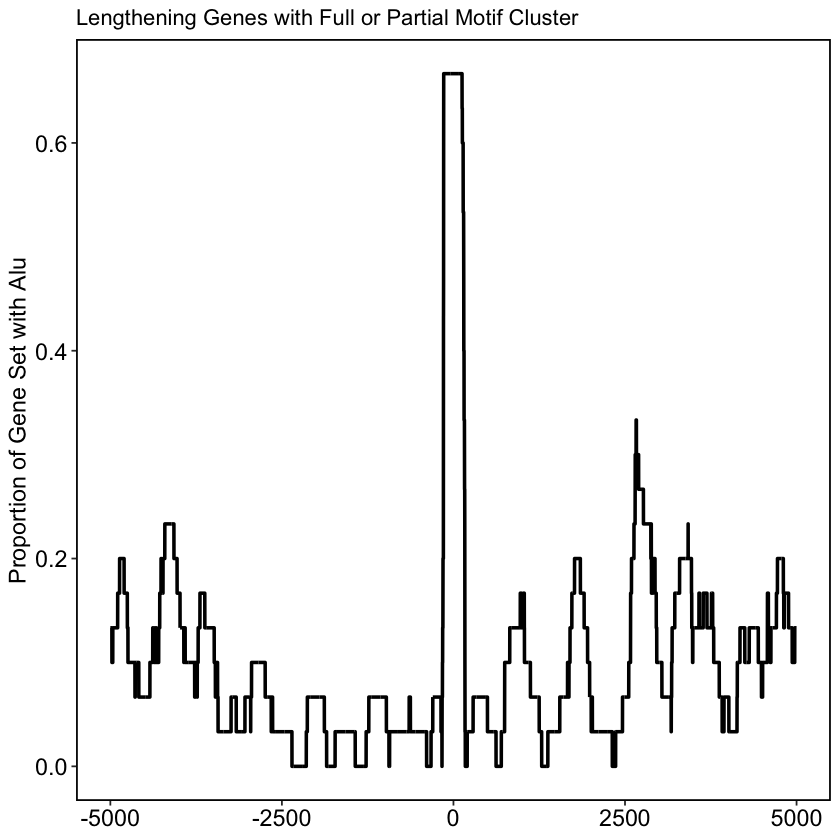

In [ ]:
# Plot Alu SINE distribution around motif cluster (full or partial) regions
lp <- ggplot(data=lpos, aes(x=position,y=porp.repName)) + 
  geom_line(stat="identity",linewidth = 1) +
  labs(y= "Proportion of Gene Set with Alu", title = 'Lengthening Genes with Full or Partial Motif Cluster') +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14),
        legend.text = element_text(colour = 'black', size = 12),
        legend.title = element_text(color = 'black', size = 14),
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
lp
# ggsave('u10_uro_lengthening_GeneswMotifClusters_PorpAluSINEAlu_dist.png', width = 14, height = 4, units = 'in', lp)

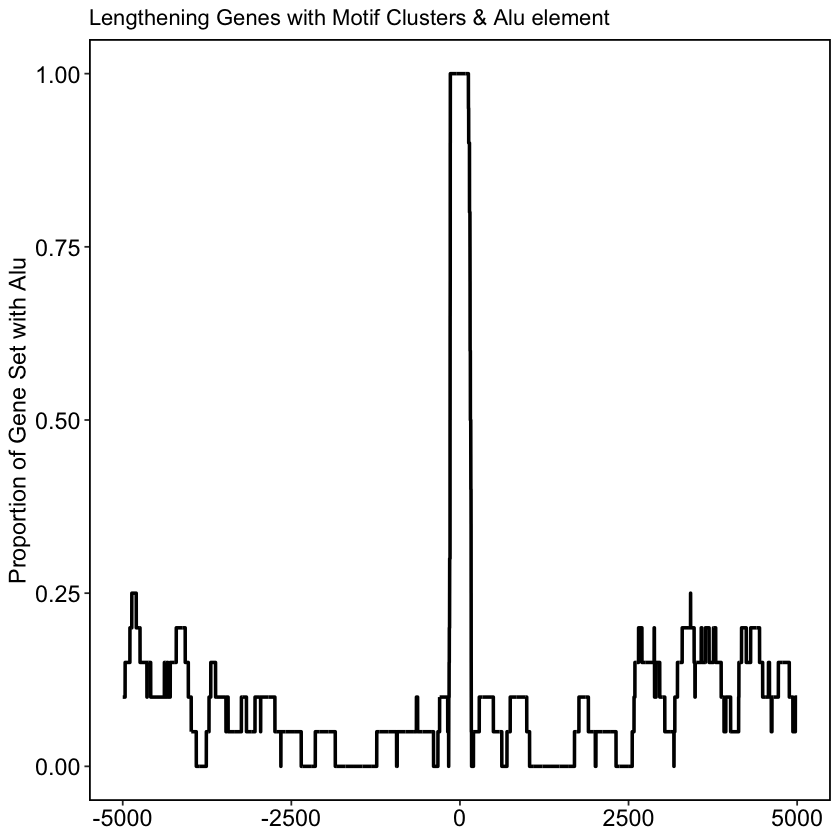

In [46]:
### Just motif cluster genes with Alu elements
lnuc_flanked_Alu <- lnuc_flanked[l_motifnuc_recompo$X[l_motifnuc_recompo$repFamily=='Alu']]
for (i in 1:length(lnuc_flanked_Alu)){
  if (i == 1) {
    lredist_Alu <- matrix(nrow = nrow(lnuc_flanked_Alu[[i]]), ncol = 0) %>% as.data.frame()
  }
  lredist_Alu <- cbind(lredist_Alu,lnuc_flanked_Alu[[i]]$repName_count > 0)
  colnames(lredist_Alu)[i] <- unique(lnuc_flanked_Alu[[i]]$X)
}

lposAlu <- data.frame(position = rownames(lredist_Alu),porp.repName = rowSums(lredist_Alu)/ncol(lredist_Alu))
lposAlu$position <- seq(-5000,5000)

lpA <- ggplot(data=lposAlu, aes(x=position,y=porp.repName)) + 
  geom_line(stat="identity",linewidth = 1) +
  labs(y= "Proportion of Gene Set with Alu", title = 'Lengthening Genes with Motif Clusters & Alu element') +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14),
        legend.text = element_text(colour = 'black', size = 12),
        legend.title = element_text(color = 'black', size = 14),
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
lpA
# ggsave('u10_uro_lengthening_GeneswMotifClustersAlu_PorpAluSINEAlu_dist.png', width = 14, height = 4, units = 'in', lpA)

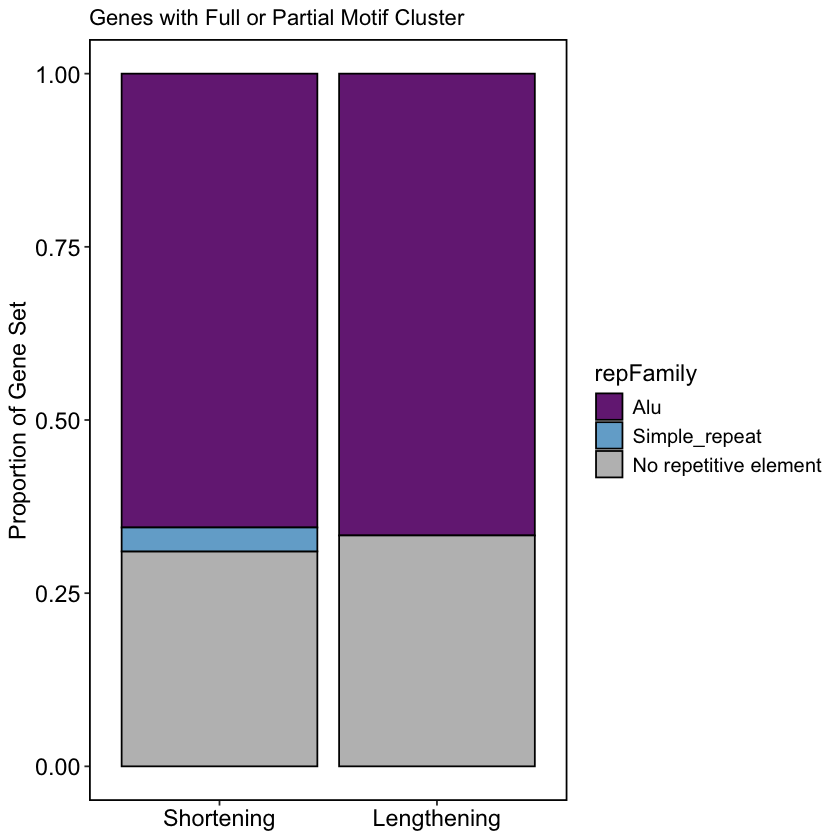

In [ ]:
# Combined RE Family Proportion Barplot
sldf <- rbind(sdf,ldf)
sldf$gene_set <- c(rep('Shortening',times=nrow(sdf)),rep('Lengthening',times=nrow(ldf)))
sldf$gene_set <- factor(sldf$gene_set, levels = c('Shortening','Lengthening'))
sldf$repFamily <- factor(sldf$repFamily,levels=c('Alu','Simple_repeat','No repetitive element'))
cols <- c('Alu' = '#762a83','Simple_repeat'='#74add1','No repetitive element'='grey')
b <- ggplot(sldf, aes(fill=repFamily, y=proportion, x=gene_set)) + 
  geom_bar(stat="identity", width=0.9,color='black',linewidth=0.5) + 
  scale_fill_manual(values=cols) +
  labs(y= "Proportion of Gene Set", title = 'Genes with Full or Partial Motif Cluster') +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14),
        legend.text = element_text(colour = 'black', size = 12),
        legend.title = element_text(color = 'black', size = 14),
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
b
# ggsave('u10_uro_GeneswMotifClusters_REdist.png', width = 8, height = 8, units = 'in', b)

### Testing
Group 1: Genes with Motif Cluster (Full or Partial)

Group 2: Genes with Motifs but not cluster

Group 3: Genes with no motif

#### Shortening

In [57]:
#### All Genes (with or without Motif Cluster)
## Shortening
# Coordinate Expansion
snuc_ag <- apply(sutr3_bed,1,function(x){
  df <- data.frame(chr = rep(x[1],times=length(seq(x[2],x[3]))),
                   start = seq(x[2],x[3]),
                   end = seq(x[2],x[3]),
                   strand = rep(x[6],times=length(seq(x[2],x[3]))))
  df$X <- x[4]
  meme <- subset(smemeres, seq_name %in% x[4])
  if(nrow(meme)==0){
    df$meme <- 'no_motif'
  } else {
    df$meme <- NA
    for (i in 1:nrow(meme)){
      meme_range <- seq(meme$start[i],meme$end[i])
      df$meme[df$start %in% meme_range[1]:meme_range[2]] <- meme$meme_name[i]
    }
    df$meme[is.na(df$meme)] <- 'no_motif'
  }
  return(df)
})
names(snuc_ag) <- sutr3_bed$seq_name
# Annotate whether or not a nucleotide overlaps with any RE
snuc_ag_re_annot <- mclapply(snuc_ag,function(x){
  x <- makeGRanges(x,strand=T)
  x_re_annot <- repeat_elt_annot(x,repeat_elt_gr) %>% as.data.frame()
  rep_colsidx <- grep('^rep',colnames(x_re_annot))
  x_re_annot$re_or_not <- apply(x_re_annot,1,function(x){
    if(all(is.na(x[rep_colsidx]))){
      return(FALSE)
    } else {
      return(TRUE)
    }
  })
  return(x_re_annot)
}, mc.cores = 4)

snuc_ag_re_annot_bu <- snuc_ag_re_annot # back up
snuc_ag_re_annot <- do.call('rbind',snuc_ag_re_annot) %>% as.data.frame()
snuc_ag_re_annot$re_or_not <- apply(snuc_ag_re_annot,1,function(x){
  rep_colsidx <- grep('^rep',colnames(snuc_ag_re_annot))
  if(all(is.na(x[rep_colsidx]))){
    return(FALSE)
  } else {
    return(TRUE)
  }
})

# Grouping Genes
sgroup1 <- names(snuc) # Genes with Motif Cluster (full or partial)
sgroup2 <- setdiff(unique(smemeres$seq_name),names(snuc)) # Genes with Motif but no Motif Cluster
sgroup3 <- setdiff(unique(sutr3_bed$seq_name),c(sgroup1,sgroup2)) # Genes without Motif

snuc_ag_re_annot$group <- ifelse(snuc_ag_re_annot$meme=='no_motif','No Motif','Motif')
snuc_ag_re_annot$group[snuc_ag_re_annot$X %in% sgroup1] <- paste('Group1:',snuc_ag_re_annot$group[snuc_ag_re_annot$X %in% sgroup1])
snuc_ag_re_annot$group[snuc_ag_re_annot$X %in% sgroup2] <- paste('Group2:',snuc_ag_re_annot$group[snuc_ag_re_annot$X %in% sgroup2])
snuc_ag_re_annot$group[snuc_ag_re_annot$X %in% sgroup3] <- paste('Group3:',snuc_ag_re_annot$group[snuc_ag_re_annot$X %in% sgroup3])

snuc_ag_re_percent <- snuc_ag_re_annot %>% group_by(X,group) %>% summarize(re_nuc_pct = sum(re_or_not)/n())

`summarise()` has grouped output by 'X'. You can override using the `.groups`
argument.


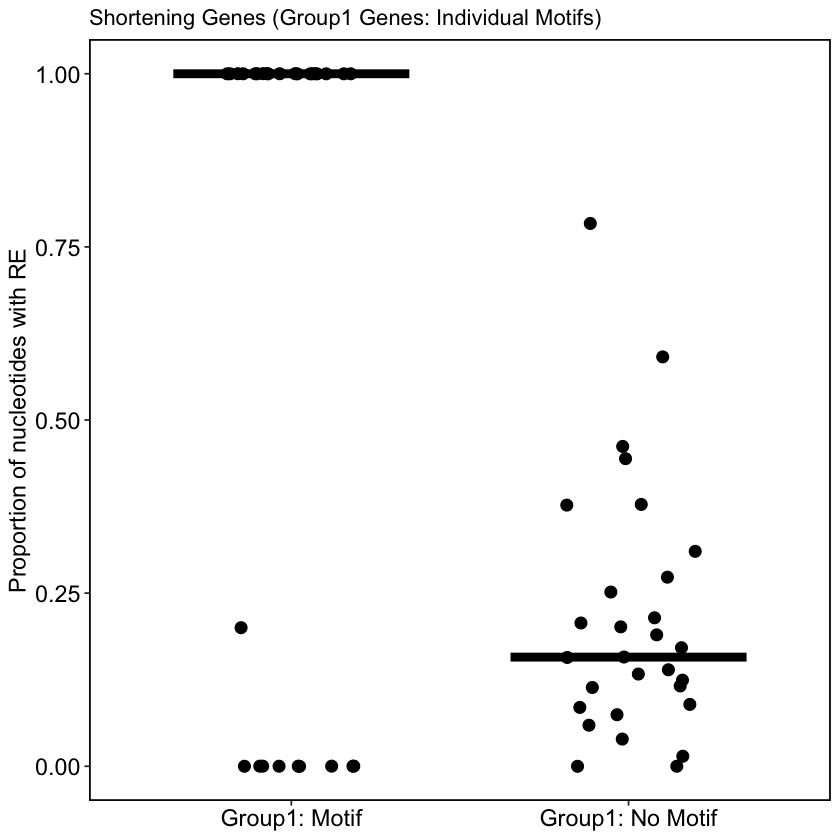

In [58]:
# Only plot Group 1 Genes
snuc_ag_re_percent_g1 <- snuc_ag_re_percent %>% filter(group %in% c('Group1: Motif','Group1: No Motif'))

p3 <- ggplot(snuc_ag_re_percent_g1, aes(x=group, y=re_nuc_pct)) + geom_boxplot(outlier.shape = NA, color = 'white') +
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123)) + 
  stat_summary(fun = median, geom = "crossbar", color = "black", width = 0.7, linewidth = 1) +
  labs(y= "Proportion of nucleotides with RE",title = "Shortening Genes (Group1 Genes: Individual Motifs)") +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p3

# ggsave('u10_uro_shortening_Group1GenesIndvMotifs_PorpNucWRE.png',width = 8, height = 8, units = 'in',p3)

In [59]:
### Testing
test_combn <- combn(unique(snuc_ag_re_percent$group),2)
for (i in 1:ncol(test_combn)) {
  print(test_combn[,i])
  data1 <- subset(snuc_ag_re_percent, group %in% test_combn[1,i])
  data2 <- subset(snuc_ag_re_percent, group %in% test_combn[2,i])
  res <- wilcox.test(data1$re_nuc_pct, data2$re_nuc_pct)
  print(res)
  rm(res,data1,data2,i)
}


[1] "Group2: Motif"    "Group2: No Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 1945, p-value = 1.15e-06
alternative hypothesis: true location shift is not equal to 0

[1] "Group2: Motif"    "Group3: No Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 3683, p-value = 1.979e-14
alternative hypothesis: true location shift is not equal to 0

[1] "Group2: Motif" "Group1: Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 739, p-value = 0.8725
alternative hypothesis: true location shift is not equal to 0

[1] "Group2: Motif"    "Group1: No Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 1142, p-value = 1.196e-05
alternative hypothesis: true location shift is not equal to 0

[1] "Group2: No Motif" "Group3: No Motif"

	Wilcoxon rank sum test with continu

Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 577, p-value = 0.0132
alternative hypothesis: true location shift is not equal to 0



`summarise()` has grouped output by 'X'. You can override using the `.groups`
argument.


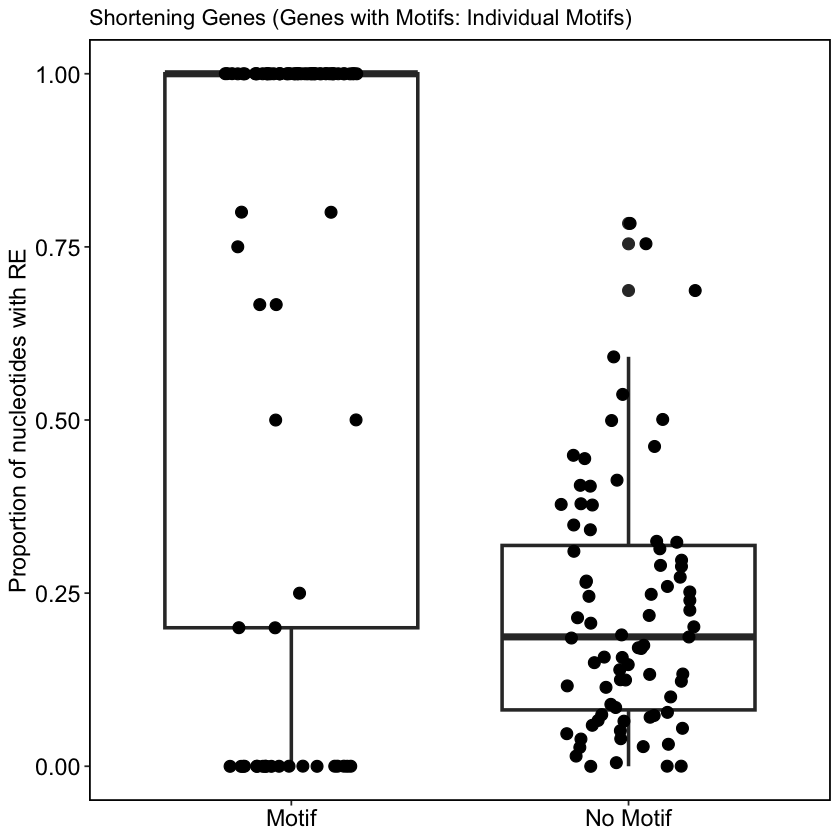

In [60]:
# Plot group 1 and group 2 genes only (genes with motifs)
snuc_amg_re_annot <- snuc_ag_re_annot[snuc_ag_re_annot$X %in% c(sgroup1,sgroup2),]
snuc_amg_re_annot$group <- ifelse(snuc_amg_re_annot$meme=='no_motif','No Motif','Motif')
snuc_amg_re_percent <- snuc_amg_re_annot %>% group_by(X,group) %>% summarize(re_nuc_pct = sum(re_or_not)/n())

p4 <- ggplot(snuc_amg_re_percent, aes(x=group, y=re_nuc_pct)) + geom_boxplot(outlier.size = 3, linewidth = 1) + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123)) + labs(y= "Proportion of nucleotides with RE",
                                                                         title = "Shortening Genes (Genes with Motifs: Individual Motifs)") +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p4

# ggsave('u10_uro_shortening_GenesWIndvMotifs_PorpNucWRE.png',width = 8, height = 8, units = 'in',p4)

In [61]:
### Testing
snuc_amg_re_percent <- reshape(as.data.frame(snuc_amg_re_percent),idvar = 'X', 
                        timevar = 'group', direction = 'wide')
snuc_amg_re_percent$motif_nomotif <- snuc_amg_re_percent$re_nuc_pct.Motif - 
  snuc_amg_re_percent$`re_nuc_pct.No Motif`
shapiro.test(snuc_amg_re_percent$motif_nomotif)

snuc_amg_wilcoxon_result = wilcox.test(snuc_amg_re_percent$re_nuc_pct.Motif, 
                                       snuc_amg_re_percent$`re_nuc_pct.No Motif`, paired = TRUE,
                                alternative = "greater")
snuc_amg_wilcoxon_result



	Shapiro-Wilk normality test

data:  snuc_amg_re_percent$motif_nomotif
W = 0.86678, p-value = 7.068e-07



	Wilcoxon signed rank test with continuity correction

data:  snuc_amg_re_percent$re_nuc_pct.Motif and snuc_amg_re_percent$`re_nuc_pct.No Motif`
V = 2720, p-value = 3.876e-11
alternative hypothesis: true location shift is greater than 0


#### Lengthening

In [62]:
## Lengthening
# Coordinate Expansion
lnuc_ag <- apply(lutr3_bed,1,function(x){
  df <- data.frame(chr = rep(x[1],times=length(seq(x[2],x[3]))),
                   start = seq(x[2],x[3]),
                   end = seq(x[2],x[3]),
                   strand = rep(x[6],times=length(seq(x[2],x[3]))))
  df$X <- x[4]
  meme <- subset(lmemeres, seq_name %in% x[4])
  if(nrow(meme)==0){
    df$meme <- 'no_motif'
  } else {
    df$meme <- NA
    for (i in 1:nrow(meme)){
      meme_range <- seq(meme$start[i],meme$end[i])
      df$meme[df$start %in% meme_range[1]:meme_range[2]] <- meme$meme_name[i]
    }
    df$meme[is.na(df$meme)] <- 'no_motif'
  }
  return(df)
})
names(lnuc_ag) <- lutr3_bed$seq_name
# Annotate whether or not a nucleotide overlaps with any RE
lnuc_ag_re_annot <- mclapply(lnuc_ag,function(x){
  x <- makeGRanges(x,strand=T)
  x_re_annot <- repeat_elt_annot(x,repeat_elt_gr) %>% as.data.frame()
  rep_colsidx <- grep('^rep',colnames(x_re_annot))
  x_re_annot$re_or_not <- apply(x_re_annot,1,function(x){
    if(all(is.na(x[rep_colsidx]))){
      return(FALSE)
    } else {
      return(TRUE)
    }
  })
  return(x_re_annot)
}, mc.cores = 4)

lnuc_ag_re_annot_bu <- lnuc_ag_re_annot # back up
lnuc_ag_re_annot <- do.call('rbind',lnuc_ag_re_annot) %>% as.data.frame()

lnuc_ag_re_annot$re_or_not <- apply(lnuc_ag_re_annot,1,function(x){
  rep_colsidx <- grep('^rep',colnames(lnuc_ag_re_annot))
  if(all(is.na(x[rep_colsidx]))){
    return(FALSE)
  } else {
    return(TRUE)
  }
})

# Grouping Genes
lgroup1 <- names(lnuc)
lgroup2 <- setdiff(unique(lmemeres$seq_name),names(lnuc))
lgroup3 <- setdiff(unique(lutr3_bed$seq_name),c(lgroup1,lgroup2))

lnuc_ag_re_annot$group <- ifelse(lnuc_ag_re_annot$meme=='no_motif','No Motif','Motif')
lnuc_ag_re_annot$group[lnuc_ag_re_annot$X %in% lgroup1] <- paste('Group1:',lnuc_ag_re_annot$group[lnuc_ag_re_annot$X %in% lgroup1])
lnuc_ag_re_annot$group[lnuc_ag_re_annot$X %in% lgroup2] <- paste('Group2:',lnuc_ag_re_annot$group[lnuc_ag_re_annot$X %in% lgroup2])
lnuc_ag_re_annot$group[lnuc_ag_re_annot$X %in% lgroup3] <- paste('Group3:',lnuc_ag_re_annot$group[lnuc_ag_re_annot$X %in% lgroup3])

lnuc_ag_re_percent <- lnuc_ag_re_annot %>% group_by(X,group) %>% summarize(re_nuc_pct = sum(re_or_not)/n())

`summarise()` has grouped output by 'X'. You can override using the `.groups`
argument.


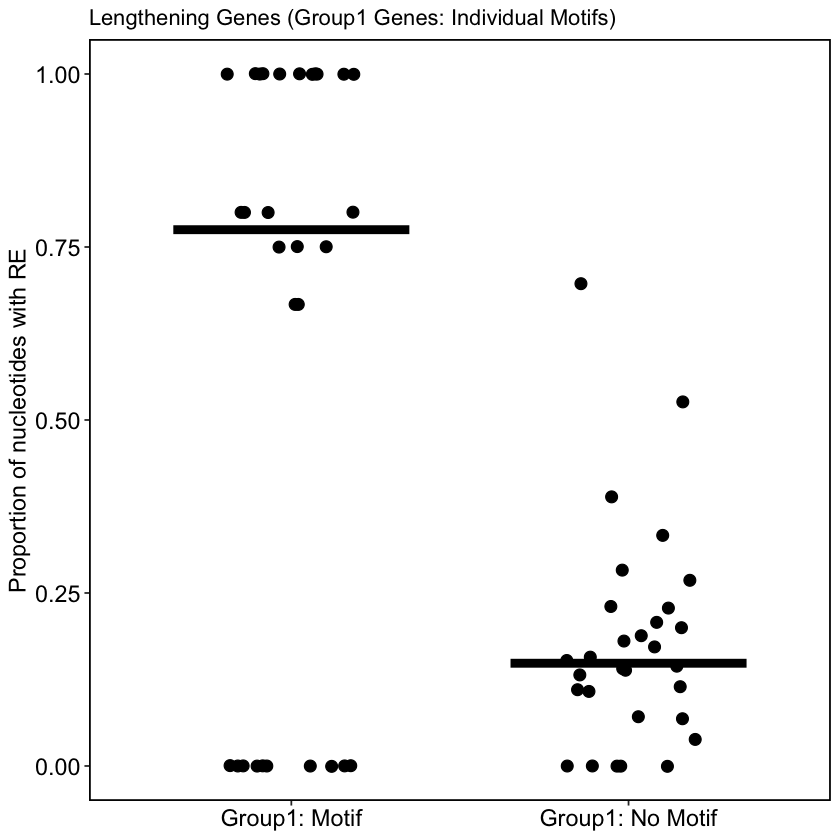

In [63]:
# Only plot Group 1 Genes
lnuc_ag_re_percent_g1 <- lnuc_ag_re_percent %>% filter(group %in% c('Group1: Motif','Group1: No Motif'))

p5 <- ggplot(lnuc_ag_re_percent_g1, aes(x=group, y=re_nuc_pct)) + geom_boxplot(outlier.shape = NA, color = 'white') + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123)) + 
  stat_summary(fun = median, geom = "crossbar", color = "black", width = 0.7, linewidth = 1) +
  labs(y= "Proportion of nucleotides with RE",title = "Lengthening Genes (Group1 Genes: Individual Motifs)") +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p5

# ggsave('u10_uro_lengthening_Group1GenesIndvMotifs_PorpNucWRE.png',width = 8, height = 8, units = 'in',p5)

In [64]:
### Testing
test_combn <- combn(unique(lnuc_ag_re_percent$group),2)
for (i in 1:ncol(test_combn)) {
  print(test_combn[,i])
  data1 <- subset(lnuc_ag_re_percent, group %in% test_combn[1,i])
  data2 <- subset(lnuc_ag_re_percent, group %in% test_combn[2,i])
  res <- wilcox.test(data1$re_nuc_pct, data2$re_nuc_pct)
  print(res)
  rm(res,data1,data2,i)
}

## "Group3: No Motif" v. "Group1: Motif"   
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 470, p-value = 2.603e-06
# alternative hypothesis: true location shift is not equal to 0

## "Group3: No Motif" v. "Group1: No Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 391, p-value = 1.727e-07
# alternative hypothesis: true location shift is not equal to 0

## "Group3: No Motif" "Group2: Motif"   
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 670, p-value = 9.977e-05
# alternative hypothesis: true location shift is not equal to 0

## "Group3: No Motif" v. "Group2: No Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 360, p-value = 2.371e-09
# alternative hypothesis: true location shift is not equal to 0

## "Group1: Motif" v. "Group1: No Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 623, p-value = 0.00991
# alternative hypothesis: true location shift is not equal to 0

## "Group1: Motif" v. "Group2: Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 574.5, p-value = 0.3656
# alternative hypothesis: true location shift is not equal to 0

## "Group1: Motif" v. "Group2: No Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 690, p-value = 0.01512
# alternative hypothesis: true location shift is not equal to 0

## "Group1: No Motif" v."Group2: Motif"   
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 399, p-value = 0.1309
# alternative hypothesis: true location shift is not equal to 0

## "Group1: No Motif" v. "Group2: No Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 536, p-value = 0.7314
# alternative hypothesis: true location shift is not equal to 0

## "Group2: Motif" v. "Group2: No Motif"
# Wilcoxon rank sum test with continuity correction
# data:  data1$re_nuc_pct and data2$re_nuc_pct
# W = 687, p-value = 0.1794
# alternative hypothesis: true location shift is not equal to 0

[1] "Group3: No Motif" "Group1: Motif"   

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 470, p-value = 2.603e-06
alternative hypothesis: true location shift is not equal to 0

[1] "Group3: No Motif" "Group1: No Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 391, p-value = 1.727e-07
alternative hypothesis: true location shift is not equal to 0

[1] "Group3: No Motif" "Group2: Motif"   

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 670, p-value = 9.977e-05
alternative hypothesis: true location shift is not equal to 0

[1] "Group3: No Motif" "Group2: No Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 360, p-value = 2.371e-09
alternative hypothesis: true location shift is not equal to 0

[1] "Group1: Motif"    "Group1: No Motif"


Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 623, p-value = 0.00991
alternative hypothesis: true location shift is not equal to 0

[1] "Group1: Motif" "Group2: Motif"


Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 574.5, p-value = 0.3656
alternative hypothesis: true location shift is not equal to 0

[1] "Group1: Motif"    "Group2: No Motif"


Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 690, p-value = 0.01512
alternative hypothesis: true location shift is not equal to 0

[1] "Group1: No Motif" "Group2: Motif"   


Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 399, p-value = 0.1309
alternative hypothesis: true location shift is not equal to 0

[1] "Group1: No Motif" "Group2: No Motif"


Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 536, p-value = 0.7314
alternative hypothesis: true location shift is not equal to 0

[1] "Group2: Motif"    "Group2: No Motif"


Warning message in wilcox.test.default(data1$re_nuc_pct, data2$re_nuc_pct):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  data1$re_nuc_pct and data2$re_nuc_pct
W = 687, p-value = 0.1794
alternative hypothesis: true location shift is not equal to 0



`summarise()` has grouped output by 'X'. You can override using the `.groups`
argument.


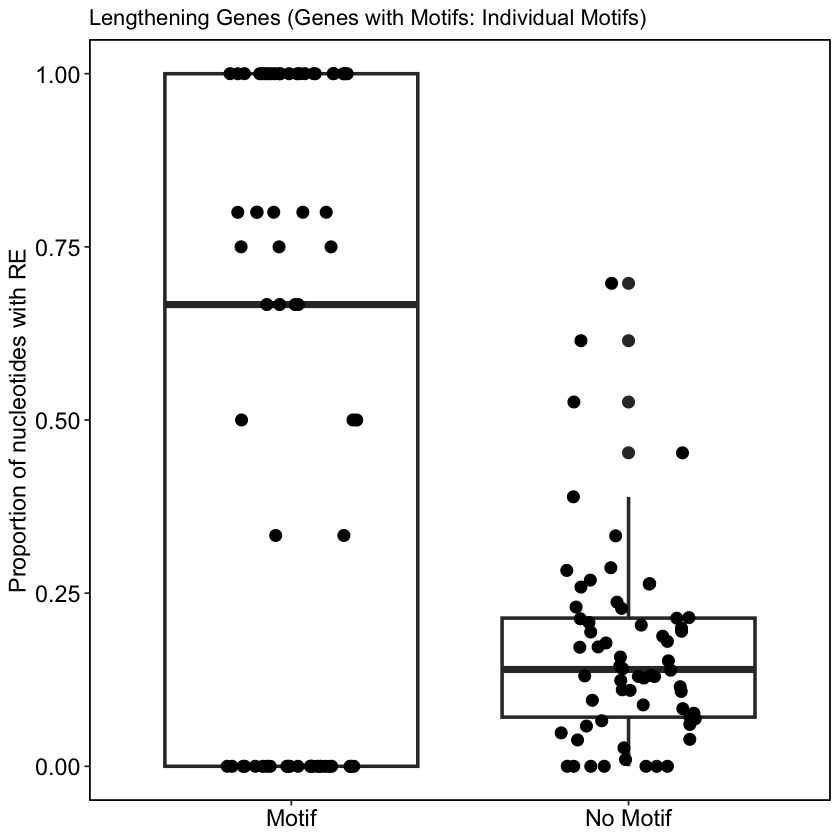

In [65]:
lnuc_amg_re_annot <- lnuc_ag_re_annot[lnuc_ag_re_annot$X %in% c(lgroup1,lgroup2),]
lnuc_amg_re_annot$group <- ifelse(lnuc_amg_re_annot$meme=='no_motif','No Motif','Motif')
lnuc_amg_re_percent <- lnuc_amg_re_annot %>% group_by(X,group) %>% summarize(re_nuc_pct = sum(re_or_not)/n())

p6 <- ggplot(lnuc_amg_re_percent, aes(x=group, y=re_nuc_pct)) + geom_boxplot(outlier.size = 3, linewidth = 1) + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123)) + labs(y= "Proportion of nucleotides with RE",
                                                                         title = "Lengthening Genes (Genes with Motifs: Individual Motifs)") +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(colour = "black", size = 14), 
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p6

# ggsave('u10_uro_lengthening_GenesWIndvMotifs_PorpNucWRE.png',width = 8, height = 8, units = 'in',p6)

In [ ]:
### Testing
lnuc_amg_re_percent <- reshape(as.data.frame(lnuc_amg_re_percent),idvar = 'X', 
                               timevar = 'group', direction = 'wide')
lnuc_amg_re_percent$motif_nomotif <- lnuc_amg_re_percent$re_nuc_pct.Motif - 
  lnuc_amg_re_percent$`re_nuc_pct.No Motif`
shapiro.test(lnuc_amg_re_percent$motif_nomotif)

lnuc_amg_wilcoxon_result = wilcox.test(lnuc_amg_re_percent$re_nuc_pct.Motif, 
                                       lnuc_amg_re_percent$`re_nuc_pct.No Motif`, paired = TRUE,
                                       alternative = "greater")
lnuc_amg_wilcoxon_result


	Shapiro-Wilk normality test

data:  lnuc_amg_re_percent$motif_nomotif
W = 0.90495, p-value = 0.0001236



	Wilcoxon signed rank test with continuity correction

data:  lnuc_amg_re_percent$re_nuc_pct.Motif and lnuc_amg_re_percent$`re_nuc_pct.No Motif`
V = 1482, p-value = 9.746e-08
alternative hypothesis: true location shift is greater than 0


### Supplementary Table S6

In [69]:
tbl <- readxl::read_excel('~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/meme_motif_results/supplemental_table3.xlsx',
                          sheet = 'weighted_UTR3_index')
tbl <- tbl %>% select(gene, type)
tbl$Motif <- NA
tbl$Clustered_Motif <- NA
tbl$Clustered_Motif_Chr <- NA
tbl$Clustered_Motif_Start <- NA
tbl$Clustered_Motif_End <- NA
tbl$Clustered_Motif_Strand <- NA
tbl$Alu <- NA
tbl <- as.data.frame(tbl)
motif_cluster_genes <- lapply(c(sbin_annot,lbin_annot),function(x){return(unique(x$full_or_partial))}) %>% unlist()
names(motif_cluster_genes) <- strsplit(names(motif_cluster_genes),'_') %>% sapply(.,'[[',1)
motif_cluster_genes_coordinates <- lapply(c(sbin_annot,lbin_annot),function(x){
  chr <- x$chr %>% unique
  coord <- range(as.integer(unlist(x[x$motif_cluster=='motif_cluster',c('start','end')])))
  strand <- x$strand %>% unique
  return(c(chr,coord,strand))
})
names(motif_cluster_genes_coordinates) <- strsplit(names(motif_cluster_genes_coordinates),'_') %>% sapply(.,'[[',1)
motif_cluster_genes_Alu <- rbind(s_motifnuc_recompo,l_motifnuc_recompo) %>% filter(repFamily=='Alu')
motif_cluster_genes_Alu <- strsplit(motif_cluster_genes_Alu$X,'_') %>% sapply(.,'[[',1)
  
all_memes <- rbind(smemeres,lmemeres)
all_memes$gene <- strsplit(all_memes$seq_name,'_') %>% sapply(.,'[[',1)
tbl$Motif <- ifelse(tbl$gene %in% all_memes$gene,TRUE,FALSE)
tbl$Clustered_Motif[tbl$gene %in% names(motif_cluster_genes[motif_cluster_genes==TRUE])] <- 'Full'
tbl$Clustered_Motif[tbl$gene %in% names(motif_cluster_genes[motif_cluster_genes==FALSE])] <- 'Partial'
tbl <- apply(tbl,1,function(x){
  if(x[1] %in% names(motif_cluster_genes_coordinates)){
    x[5:8] <- motif_cluster_genes_coordinates[[x[1]]]
  }
  return(x)
}) %>% t() %>% as.data.frame()
tbl$Alu[!is.na(tbl$Clustered_Motif)] <- FALSE 
tbl$Alu <- ifelse(tbl$gene %in% motif_cluster_genes_Alu,TRUE,tbl$Alu)
# write.table(tbl,'~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/meme_motif_results/supplemental_table3_meme_analysis_summary.txt',quote = F, sep = '\t', row.names = F, col.names = T)


In [70]:
head(tbl)

,gene,type,Motif,Clustered_Motif,Clustered_Motif_Chr,Clustered_Motif_Start,Clustered_Motif_End,Clustered_Motif_Strand,Alu
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ABHD2,UTR3 shortening,TRUE,NA,NA,NA,NA,NA,NA
2,ACADM,UTR3 shortening,FALSE,NA,NA,NA,NA,NA,NA
3,ACOT13,UTR3 shortening,TRUE,Partial,chr6,24702103,24702392,+,FALSE
4,ACOX1,UTR3 shortening,TRUE,Partial,chr17,75942170,75942449,-,FALSE
5,ACP2,UTR3 shortening,TRUE,NA,NA,NA,NA,NA,NA
6,ADAMTSL4-AS2,UTR3 shortening,TRUE,NA,NA,NA,NA,NA,NA
